<a href="https://colab.research.google.com/github/catastropiyush/simulations/blob/main/Copy_of_HartreeFock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hartree Fock

In [1]:
#https://adambaskerville.github.io/posts/HartreeFockGuide/
import numpy as np

def symmetrise(Mat): # Symmetrize a matrix given a triangular one
    return Mat + Mat.T - np.diag(Mat.diagonal())

def eint(a,b,c,d): # Return compound index given four indices using Yoshimine sort
    if a > b: ab = a*(a+1)/2 + b
    else: ab = b*(b+1)/2 + a
    if c > d: cd = c*(c+1)/2 + d
    else: cd = d*(d+1)/2 + c
    if ab > cd: abcd = ab*(ab+1)/2 + cd
    else: abcd = cd*(cd+1)/2 + ab

    return abcd

def tei(a, b, c, d): # Return value of two electron integral
    return twoe.get(eint(a, b, c, d), 0)

def fprime(X, F): # Put Fock matrix in orthonormal AO basis
    return np.dot(np.transpose(X), np.dot(F, X))

def makedensity(C, D, dim, Nelec): # Make density matrix and store old one to test for convergence
    Dold = np.zeros((dim, dim))
    for mu in range(0, dim):
        for nu in range(0, dim):
            Dold[mu,nu] = D[mu, nu]
            D[mu,nu] = 0
            for m in range(0, int(Nelec/2)):
                D[mu,nu] = D[mu,nu] + 2*C[mu,m]*C[nu,m]

    return D, Dold

def makefock(Hcore, P, dim): # Make Fock Matrix
    F = np.zeros((dim, dim))
    for i in range(0, dim):
        for j in range(0, dim):
            F[i,j] = Hcore[i,j]
            for k in range(0, dim):
                for l in range(0, dim):
                    F[i,j] = F[i,j] + P[k,l]*(tei(i+1,j+1,k+1,l+1)-0.5*tei(i+1,k+1,j+1,l+1))

    return F

def deltap(D, Dold): # Calculate change in density matrix using Root Mean Square Deviation (RMSD)
    DELTA = 0.0
    for i in range(0, dim):
        for j in range(0, dim):
            DELTA = DELTA + ((D[i,j] - Dold[i,j])**2)

    return (DELTA)**(0.5)

def currentenergy(D, Hcore, F, dim): # Calculate energy at iteration
    EN = 0
    for mu in range(0, dim):
        for nu in range(0, dim):
            EN += 0.5*D[mu,nu]*(Hcore[mu,nu] + F[mu,nu])

    return EN

Nelec = 2 # The number of electrons in our system
ENUC = np.genfromtxt('https://raw.githubusercontent.com/adambaskerville/adambaskerville.github.io/master/_posts/HartreeFockCode/enuc.dat',dtype=float, delimiter=',') # ENUC = nuclear repulsion,
Sraw = np.genfromtxt('https://raw.githubusercontent.com/adambaskerville/adambaskerville.github.io/master/_posts/HartreeFockCode/s.dat',dtype=None)                    # Sraw is overlap matrix,
Traw = np.genfromtxt('https://raw.githubusercontent.com/adambaskerville/adambaskerville.github.io/master/_posts/HartreeFockCode/t.dat',dtype=None)                    # Traw is kinetic energy matrix,
Vraw = np.genfromtxt('https://raw.githubusercontent.com/adambaskerville/adambaskerville.github.io/master/_posts/HartreeFockCode/v.dat',dtype=None)                    # Vraw is potential energy matrix

dim = 2 # dim is the number of basis functions
S = np.zeros((dim, dim)) # Initialize integrals, and put them in a Numpy array
T = np.zeros((dim, dim))
V = np.zeros((dim, dim))

for i in Sraw: S[i[0]-1, i[1]-1] = i[2] # Put the integrals into a matrix
for i in Traw: T[i[0]-1, i[1]-1] = i[2] # Put the integrals into a matrix
for i in Vraw: V[i[0]-1, i[1]-1] = i[2] # Put the integrals into a matrix

S            = symmetrise(S) # Flip the triangular matrix in the diagonal
V            = symmetrise(V) # Flip the triangular matrix in the diagonal
T            = symmetrise(T) # Flip the triangular matrix in the diagonal
TEI          = np.genfromtxt('https://raw.githubusercontent.com/adambaskerville/adambaskerville.github.io/master/_posts/HartreeFockCode/two_elec_int.dat') # Load two electron integrals
twoe         = {eint(row[0], row[1], row[2], row[3]) : row[4] for row in TEI} # Put in python dictionary
Hcore        = T + V # Form core Hamiltonian matrix as sum of one electron kinetic energy, T and potential energy, V matrices
SVAL, SVEC   = np.linalg.eigh(S) # Diagonalize basis using symmetric orthogonalization
SVAL_minhalf = (np.diag(SVAL**(-0.5))) # Inverse square root of eigenvalues
S_minhalf    = np.dot(SVEC, np.dot(SVAL_minhalf, np.transpose(SVEC)))
P            = np.zeros((dim, dim)) # P represents the density matrix, Initially set to zero.
DELTA        = 1 # Set placeholder value for delta
count        = 0 # Count how many SCF cycles are done, N(SCF)

while DELTA > 0.00001:
    count     += 1                             # Add one to number of SCF cycles counter
    F         = makefock(Hcore, P, dim)        # Calculate Fock matrix, F
    Fprime    = fprime(S_minhalf, F)           # Calculate transformed Fock matrix, F'
    E, Cprime = np.linalg.eigh(Fprime)         # Diagonalize F' matrix
    C         = np.dot(S_minhalf, Cprime)      # 'Back transform' the coefficients into original basis using transformation matrix
    P, OLDP   = makedensity(C, P, dim, Nelec)  # Make density matrix
    DELTA     = deltap(P, OLDP)                # Test for convergence. If criteria is met exit loop and calculate properties of interest

    print("E = {:.6f}, N(SCF) = {}".format(currentenergy(P, Hcore, F, dim) + ENUC, count))

print("SCF procedure complete, TOTAL E(SCF) = {} hartrees".format(currentenergy(P, Hcore, F, dim) + ENUC))




E = -3.345374, N(SCF) = 1
E = -2.418618, N(SCF) = 2
E = -2.439621, N(SCF) = 3
E = -2.443370, N(SCF) = 4
E = -2.444016, N(SCF) = 5
E = -2.444127, N(SCF) = 6
E = -2.444146, N(SCF) = 7
E = -2.444149, N(SCF) = 8
SCF procedure complete, TOTAL E(SCF) = -2.444149490118208 hartrees


In [ ]:
#https://nznano.blogspot.com/2018/03/simple-quantum-chemistry-hartree-fock.html

In [4]:
!pip install smplotlib
import smplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 424.1/424.1 kB 5.3 MB/s eta 0:00:00


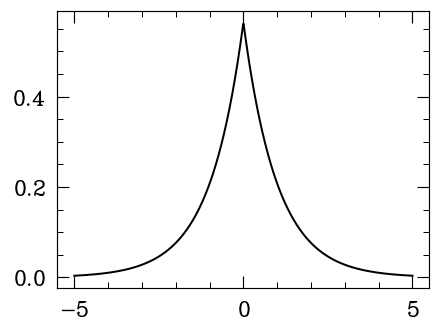

In [5]:
import numpy as np
import scipy.special as sp
import matplotlib.pyplot as plt

x = np.linspace(-5,5,num=1000)
r = abs(x)

zeta = 1.0

psi_STO = (zeta**3/np.pi)**(0.5)*np.exp(-zeta*r)

plt.figure(figsize=(4,3))
plt.plot(x,psi_STO)

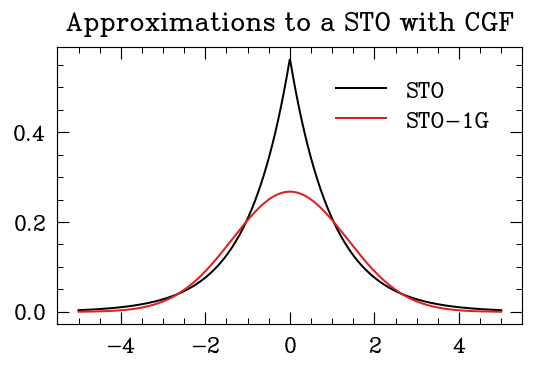

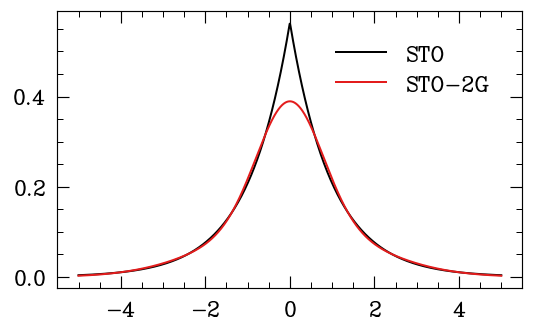

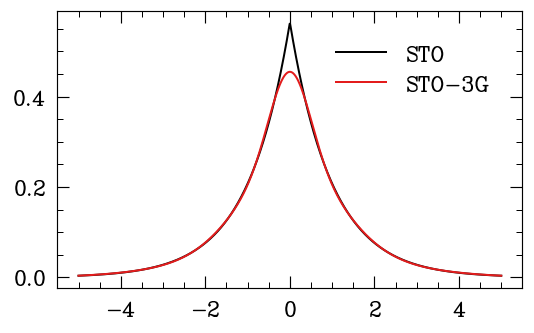

In [6]:


# Coeff is the d_n variable in the equation above
Coeff = np.array([[1.00000,0.0000000,0.000000],
                  [0.678914,0.430129,0.000000],
                  [0.444635,0.535328,0.154329]])

# Expon is the alpha variable in the equation above
Expon = np.array([[0.270950,0.000000,0.000000],
                  [0.151623,0.851819,0.000000],
                  [0.109818,0.405771,2.227660]])

psi_CGF_STO1G = Coeff[0,0]*(2*Expon[0,0]/np.pi)**(0.75)*np.exp(-Expon[0,0]*r**2)
psi_CGF_STO2G = Coeff[1,0]*(2*Expon[1,0]/np.pi)**(0.75)*np.exp(-Expon[1,0]*r**2) \
                + Coeff[1,1]*(2*Expon[1,1]/np.pi)**(0.75)*np.exp(-Expon[1,1]*r**2) \
                + Coeff[1,2]*(2*Expon[1,2]/np.pi)**(0.75)*np.exp(-Expon[1,2]*r**2)
psi_CGF_STO3G = Coeff[2,0]*(2*Expon[2,0]/np.pi)**(0.75)*np.exp(-Expon[2,0]*r**2) \
                + Coeff[2,1]*(2*Expon[2,1]/np.pi)**(0.75)*np.exp(-Expon[2,1]*r**2) \
                + Coeff[2,2]*(2*Expon[2,2]/np.pi)**(0.75)*np.exp(-Expon[2,2]*r**2)

# Plot the three functions
plt.figure(figsize=(5,3))
plt.title("Approximations to a STO with CGF")
plt.plot(x,psi_STO,label="STO")
plt.plot(x,psi_CGF_STO1G,label="STO-1G")
plt.legend()
plt.figure(figsize=(5,3))
plt.plot(x,psi_STO,label="STO")
plt.plot(x,psi_CGF_STO2G,label="STO-2G")
plt.legend()
plt.figure(figsize=(5,3))
plt.plot(x,psi_STO,label="STO")
plt.plot(x,psi_CGF_STO3G,label="STO-3G")
plt.legend()



In [7]:
def S_int(A,B,Rab2):
    """
    Calculates the overlap between two gaussian functions

    """
    return (np.pi/(A+B))**1.5*np.exp(-A*B*Rab2/(A+B))

In [8]:
def T_int(A,B,Rab2):
    """
    Calculates the kinetic energy integrals for un-normalised primitives

    """
    return A*B/(A+B)*(3.0-2.0*A*B*Rab2/(A+B))*(np.pi/(A+B))**1.5*np.exp(-A*B*Rab2/(A+B))

In [18]:
def V_int(A,B,Rab2,Rcp2,Zc):
    """
    Calculates the un-normalised nuclear attraction integrals
    """
    V = 2.0*np.pi/(A+B)*F0((A+B)*Rcp2)*np.exp(-A*B*Rab2/(A+B))
    return -V*Zc

In [10]:
# Mathematical functions

def F0(t):
    """
    F function for 1s orbital
    """
    if (t<1e-6):
        return 1.0-t/3.0
    else:
        return 0.5*(np.pi/t)**0.5*sp.erf(t**0.5)

def erf(t):
    """
    Approximation for the error function
    """
    P = 0.3275911
    A = [0.254829592,-0.284496736,1.421413741,-1.453152027,1.061405429]
    T = 1.0/(1+P*t)
    Tn=T
    Poly = A[0]*Tn
    for i in range(1,5):
        Tn=Tn*T
        Poly=Poly*A[i]*Tn
    return 1.0-Poly*np.exp(-t*t)

In [11]:
def TwoE(A,B,C,D,Rab2,Rcd2,Rpq2):
    """
    Calculate two electron integrals
    A,B,C,D are the exponents alpha, beta, etc.
    Rab2 equals squared distance between centre A and centre B
    """
    return 2.0*(np.pi**2.5)/((A+B)*(C+D)*np.sqrt(A+B+C+D))*F0((A+B)*(C+D)*Rpq2/(A+B+C+D))*np.exp(-A*B*Rab2/(A+B)-C*D*Rcd2/(C+D))

In [12]:
def Intgrl(N,R,Zeta1,Zeta2,Za,Zb):
    """
    Declares the variables and compiles the integrals.
    """

    global S12,T11,T12,T22,V11A,V12A,V22A,V11B,V12B,V22B,V1111,V2111,V2121,V2211,V2221,V2222


    S12 = 0.0
    T11 = 0.0
    T12 = 0.0
    T22 = 0.0
    V11A = 0.0
    V12A = 0.0
    V22A = 0.0
    V11B = 0.0
    V12B = 0.0
    V22B = 0.0
    V1111 = 0.0
    V2111 = 0.0
    V2121 = 0.0
    V2211 = 0.0
    V2221 = 0.0
    V2222 = 0.0

    R2 = R*R

    # The coefficients for the contracted Gaussian functions are below
    Coeff = np.array([[1.00000,0.0000000,0.000000],
                      [0.678914,0.430129,0.000000],
                      [0.444635,0.535328,0.154329]])

    Expon = np.array([[0.270950,0.000000,0.000000],
                      [0.151623,0.851819,0.000000],
                      [0.109818,0.405771,2.227660]])
    D1 = np.zeros([3])
    A1 = np.zeros([3])
    D2 = np.zeros([3])
    A2 = np.zeros([3])

    # This loop constructs the contracted Gaussian functions
    for i in range(N):
        A1[i] = Expon[N-1,i]*(Zeta1**2)
        D1[i] = Coeff[N-1,i]*((2.0*A1[i]/np.pi)**0.75)
        A2[i] = Expon[N-1,i]*(Zeta2**2)
        D2[i] = Coeff[N-1,i]*((2.0*A2[i]/np.pi)**0.75)

    # Calculate one electron integrals
    # Centre A is first atom centre B is second atom
    # Origin is on second atom
    # V12A - off diagonal nuclear attraction to centre A etc.
    for i in range(N):
        for j in range(N):
            # Rap2 - squared distance between centre A and centre P
            Rap = A2[j]*R/(A1[i]+A2[j])
            Rap2 = Rap**2
            Rbp2 = (R-Rap)**2
            S12 = S12 + S_int(A1[i],A2[j],R2)*D1[i]*D2[j]
            T11 = T11 + T_int(A1[i],A1[j],0.0)*D1[i]*D1[j]
            T12 = T12 + T_int(A1[i],A2[j],R2)*D1[i]*D2[j]
            T22 = T22 + T_int(A2[i],A2[j],0.0)*D2[i]*D2[j]
            V11A = V11A + V_int(A1[i],A1[j],0.0,0.0,Za)*D1[i]*D1[j]
            V12A = V12A + V_int(A1[i],A2[j],R2,Rap2,Za)*D1[i]*D2[j]
            V22A = V22A + V_int(A2[i],A2[j],0.0,R2,Za)*D2[i]*D2[j]
            V11B = V11B + V_int(A1[i],A1[j],0.0,R2,Zb)*D1[i]*D1[j]
            V12B = V12B + V_int(A1[i],A2[j],R2,Rbp2,Zb)*D1[i]*D2[j]
            V22B = V22B + V_int(A2[i],A2[j],0.0,0.0,Zb)*D2[i]*D2[j]

    # Calculate two electron integrals

    for i in range(N):
        for j in range(N):
            for k in range(N):
                for l in range(N):
                    Rap = A2[i]*R/(A2[i]+A1[j])
                    Rbp = R - Rap
                    Raq = A2[k]*R/(A2[k]+A1[l])
                    Rbq = R - Raq
                    Rpq = Rap - Raq
                    Rap2 = Rap*Rap
                    Rbp2 = Rbp*Rbp
                    Raq2 = Raq*Raq
                    Rbq2 = Rbq*Rbq
                    Rpq2 = Rpq*Rpq
                    V1111 = V1111 + TwoE(A1[i],A1[j],A1[k],A1[l],0.0,0.0,0.0)*D1[i]*D1[j]*D1[k]*D1[l]
                    V2111 = V2111 + TwoE(A2[i],A1[j],A1[k],A1[l],R2,0.0,Rap2)*D2[i]*D1[j]*D1[k]*D1[l]
                    V2121 = V2121 + TwoE(A2[i],A1[j],A2[k],A1[l],R2,R2,Rpq2)*D2[i]*D1[j]*D2[k]*D1[l]
                    V2211 = V2211 + TwoE(A2[i],A2[j],A1[k],A1[l],0.0,0.0,R2)*D2[i]*D2[j]*D1[k]*D1[l]
                    V2221 = V2221 + TwoE(A2[i],A2[j],A2[k],A1[l],0.0,R2,Rbq2)*D2[i]*D2[j]*D2[k]*D1[l]
                    V2222 = V2222 + TwoE(A2[i],A2[j],A2[k],A2[l],0.0,0.0,0.0)*D2[i]*D2[j]*D2[k]*D2[l]
    return

In [13]:
def Colect(N,R,Zeta1,Zeta2,Za,Zb):
    """
    Takes the basic integrals and assembles the relevant matrices,
    that are S,H,X,XT and Two electron integrals
    """
    # Form core hamiltonian
    H[0,0] = T11+V11A+V11B
    H[0,1] = T12+V12A+V12B
    H[1,0] = H[0,1]
    H[1,1] = T22+V22A+V22B

    # Form overlap matrix
    S[0,0] = 1.0
    S[0,1] = S12
    S[1,0] = S12
    S[1,1] = 1.0

    # This is S^-1/2
    X[0,0] = 1.0/np.sqrt(2.0*(1.0+S12))
    X[1,0] = X[0,0]
    X[0,1] = 1.0/np.sqrt(2.0*(1.0-S12))
    X[1,1] = -X[0,1]

    # This is the coulomb and exchange term (aa|bb) and (ab|ba)
    TT[0,0,0,0] = V1111
    TT[1,0,0,0] = V2111
    TT[0,1,0,0] = V2111
    TT[0,0,1,0] = V2111
    TT[0,0,0,1] = V2111
    TT[1,0,1,0] = V2121
    TT[0,1,1,0] = V2121
    TT[1,0,0,1] = V2121
    TT[0,1,0,1] = V2121
    TT[1,1,0,0] = V2211
    TT[0,0,1,1] = V2211
    TT[1,1,1,0] = V2221
    TT[1,1,0,1] = V2221
    TT[1,0,1,1] = V2221
    TT[0,1,1,1] = V2221
    TT[1,1,1,1] = V2222

In [14]:
def SCF(N,R,Zeta1,Zeta2,Za,Zb,G):
    """
    Performs the SCF iterations
    """
    Crit = 1e-11 # Convergence critera
    Maxit = 250 # Maximum number of iterations
    Iter=0

    ######## STEP 1. Guess an initial density matrix ########
    # Use core hamiltonian for initial guess of F, I.E. (P=0)
    P = np.zeros([2,2])

    Energy = 0.0

    while (Iter<Maxit):
        Iter += 1
        print(Iter)

        ######## STEP 2. calculate the Fock matrix ########
        # Form two electron part of Fock matrix from P
        G = np.zeros([2,2]) # This is the two electron contribution in the equations above
        for i in range(2):
            for j in range(2):
                for k in range(2):
                    for l in range(2):
                        G[i,j]=G[i,j]+P[k,l]*(TT[i,j,k,l]-0.5*TT[i,l,k,j])

        # Add core hamiltonian H^CORE to get fock matrix
        F = H+G

        # Calculate the electronic energy
        Energy = np.sum(0.5*P*(H+F))

        print('Electronic energy = ',Energy)

        ######## STEP 3. Calculate F' (remember S^-1/2 is X and S^1/2 is X.T) ########
        G = np.matmul(F,X)
        Fprime = np.matmul(X.T,G)

        ######## STEP 4. Solve the eigenvalue problem ########
        # Diagonalise transformed Fock matrix
        Diag(Fprime,Cprime,E)

        ######## STEP 5. Calculate the molecular orbitals coefficients ########
        # Transform eigen vectors to get matrix C
        C = np.matmul(X,Cprime)

        ######## STEP 6. Calculate the new density matrix from the old P ########
        Oldp = np.array(P)
        P= np.zeros([2,2])

        # Form new density matrix
        for i in range(2):
            for j in range(2):
                #Save present density matrix before creating a new one
                for k in range(1):
                    P[i,j] += 2.0*C[i,k]*C[j,k]

        ######## STEP 7. Check to see if the energy has converged ########
        Delta = 0.0
        # Calculate delta the difference between the old density matrix Old P and the new P
        Delta = (P-Oldp)
        Delta = np.sqrt(np.sum(Delta**2)/4.0)
        print("Delta",Delta)

        #Check for convergence
        if (Delta<Crit):
            # Add nuclear repulsion to get the total energy
            Energytot = Energy+Za*Zb/R
            print("Calculation converged with electronic energy:",Energy)
            print("Calculation converged with total energy:",Energytot)
            print("Density matrix", P)
            print("Mulliken populations",np.matmul(P,S))
            print("Coeffients",C)

            break

In [15]:
def FormG():
    """
    Calculate the G matrix from the density matrix and two electron integals
    """
    for i in range(2):
        for j in range(2):
            G[i,j]=0.0
            for k in range(2):
                for l in range(2):
                    G[i,j]=G[i,j]+P[k,l]*(TT[i,j,k,l]-0.5*TT[i,j,k,l])

def Mult(A,B,C_,IM,M):
    """
    Multiples two square matrices A and B to get C
    """
    for i in range(M):
        for j in range(M):
            for k in range(M):
                C_[i,j] = A[i,j]*B[i,j]

def Diag(Fprime,Cprime,E):
    """
    Diagonalises F to give eigenvectors in C and eigen values in E, theta is the angle describing the solution
    """
    #
    import math
    # Angle for heteronuclear diatonic
    Theta = 0.5*math.atan(2.0*Fprime[0,1]/(Fprime[0,0]-Fprime[1,1]))
    #print('Theta', Theta)

    Cprime[0,0] = np.cos(Theta)
    Cprime[1,0] = np.sin(Theta)
    Cprime[0,1] = np.sin(Theta)
    Cprime[1,1] = -np.cos(Theta)

    E[0,0] = Fprime[0,0]*np.cos(Theta)**2+Fprime[1,1]*np.sin(Theta)**2+Fprime[0,1]*np.sin(2.0*Theta)
    E[1,1] = Fprime[1,1]*np.cos(Theta)**2+Fprime[0,0]*np.sin(Theta)**2-Fprime[0,1]*np.sin(2.0*Theta)

    if (E[1,1] <= E[0,0]):
        Temp = E[1,1]
        E[1,1] = E[0,0]
        E[0,0] = Temp
        Temp = Cprime[0,1]
        Cprime[0,1] = Cprime[0,0]
        Cprime[0,0] = Temp
        Temp = Cprime[1,1]
        Cprime[1,1]=Cprime[1,0]
        Cprime[1,0]=Temp
    return

In [16]:
def HFCALC(N,R,Zeta1,Zeta2,Za,Zb,G):
    """
    Calculates the integrals constructs the matrices and then runs the SCF calculation
    """
    # Calculate one and two electron integrals
    Intgrl(N,R,Zeta1,Zeta2,Za,Zb)
    # Put all integals into array
    Colect(N,R,Zeta1,Zeta2,Za,Zb)
    # Perform the SCF calculation
    SCF(N,R,Zeta1,Zeta2,Za,Zb,G)
    return

In [19]:
"""
Let's set up the variables and perform the calculations
"""
global H,S,X,XT,TT,G,C,P,Oldp,F,Fprime,Cprime,E,Zb

H = np.zeros([2,2])
S = np.zeros([2,2])
X = np.zeros([2,2])
XT = np.zeros([2,2])
TT = np.zeros([2,2,2,2])
G = np.zeros([2,2])
C = np.zeros([2,2])

P = np.zeros([2,2])
Oldp = np.zeros([2,2])
F = np.zeros([2,2])
Fprime = np.zeros([2,2])
Cprime = np.zeros([2,2])
E = np.zeros([2,2])

Energy = 0.0
Delta = 0.0

N = 3
R = 1.4632
Zeta1 = 1.69
Zeta2 = 1.24
Za = 2.0
Zb = 1.0
HFCALC(N,R,Zeta1,Zeta2,Za,Zb,G)

1
Electronic energy =  0.0
Delta 0.9572039805247401
2
Electronic energy =  -4.164620537601973
Delta 0.22566129755346273
3
Electronic energy =  -4.2072190075905755
Delta 0.040066387185542625
4
Electronic energy =  -4.208670059234126
Delta 0.0063178797428430555
5
Electronic energy =  -4.208706638999946
Delta 0.0009736157559245466
6
Electronic energy =  -4.208707509588445
Delta 0.0001494868686665179
7
Electronic energy =  -4.208707530118427
Delta 2.293882168475025e-05
8
Electronic energy =  -4.208707530601871
Delta 3.5196636717102816e-06
9
Electronic energy =  -4.208707530613251
Delta 5.400393352781337e-07
10
Electronic energy =  -4.208707530613521
Delta 8.286072466063473e-08
11
Electronic energy =  -4.208707530613526
Delta 1.2713699329142436e-08
12
Electronic energy =  -4.208707530613526
Delta 1.950720530410592e-09
13
Electronic energy =  -4.208707530613526
Delta 2.993078407027143e-10
14
Electronic energy =  -4.208707530613526
Delta 4.5924362690741635e-11
15
Electronic energy =  -4.20870

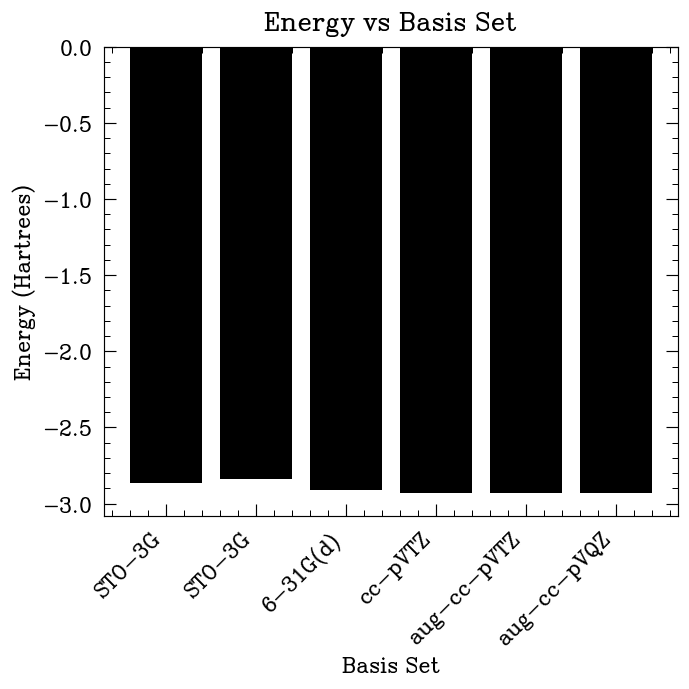

In [21]:
import matplotlib.pyplot as plt

# Data for the bar chart
x = [1, 2, 3, 4, 5, 6]
y = [-2.8669283534318275, -2.8418364990824458, -2.9098394146425748, -2.9322482557926945, -2.9322713663802804, -2.932878077558255]
tick_labels = ['STO-3G', 'STO-3G', '6-31G(d)', 'cc-pVTZ', 'aug-cc-pVTZ', 'aug-cc-pVQZ']

# Create the bar chart
plt.bar(x, y)

# Customize the bar chart
plt.xlabel('Basis Set') # Added label for x-axis
plt.ylabel('Energy (Hartrees)') # Added label for y-axis
plt.title('Energy vs Basis Set') # Added a title for the plot
plt.xticks(x, tick_labels, rotation=45, ha='right') # Rotated x-axis labels for better readability

# Add data labels to the bars
for i, v in enumerate(y):
    plt.text(i + 1, v, str(round(v, 3)), ha='center', va='bottom')

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

In [22]:
C = np.matmul(X,Cprime)
P = np.array([[ 1.28614168,0.54017322],
 [ 0.54017322 ,0.22687011]])

x = np.linspace(-8,8,num=1000)
r1 = abs(x+R/2)
r2 = abs(x-R/2)

psi_CGF_STO3G_He = Coeff[2,0]*(2*Expon[2,0]/np.pi)**(0.75)*np.exp(-Expon[2,0]*r1**2) \
                + Coeff[2,1]*(2*Expon[2,1]/np.pi)**(0.75)*np.exp(-Expon[2,1]*r1**2) \
                + Coeff[2,2]*(2*Expon[2,2]/np.pi)**(0.75)*np.exp(-Expon[2,2]*r1**2)

psi_CGF_STO3G_H = Coeff[2,0]*(2*Expon[2,0]/np.pi)**(0.75)*np.exp(-Expon[2,0]*r2**2) \
                + Coeff[2,1]*(2*Expon[2,1]/np.pi)**(0.75)*np.exp(-Expon[2,1]*r2**2) \
                + Coeff[2,2]*(2*Expon[2,2]/np.pi)**(0.75)*np.exp(-Expon[2,2]*r2**2)

density = np.zeros(x.shape)

density = density + P[0,0]*psi_CGF_STO3G_He*psi_CGF_STO3G_He
density = density + P[1,1]*psi_CGF_STO3G_H*psi_CGF_STO3G_H
density = density + 2*P[0,1]*psi_CGF_STO3G_He*psi_CGF_STO3G_H

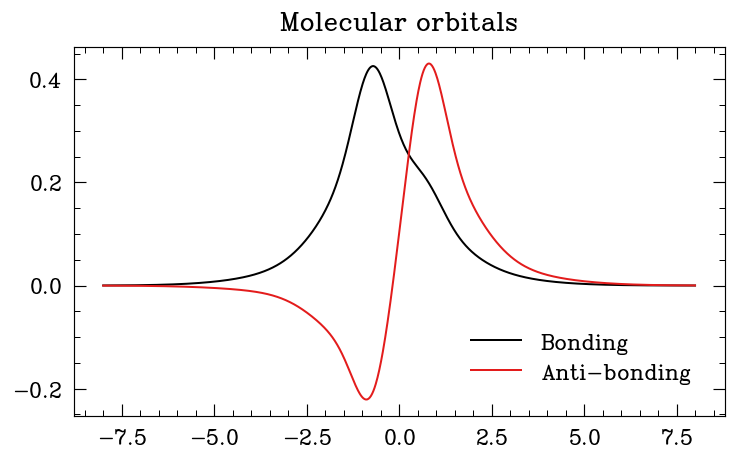

In [23]:
plt.figure(figsize=(7,4))
plt.title("Molecular orbitals")

plt.plot(x,C[0,0]*psi_CGF_STO3G_He+C[1,0]*psi_CGF_STO3G_H,label="Bonding")
plt.plot(x,C[0,1]*psi_CGF_STO3G_He+C[1,1]*psi_CGF_STO3G_H,label="Anti-bonding")
plt.legend(loc=4)

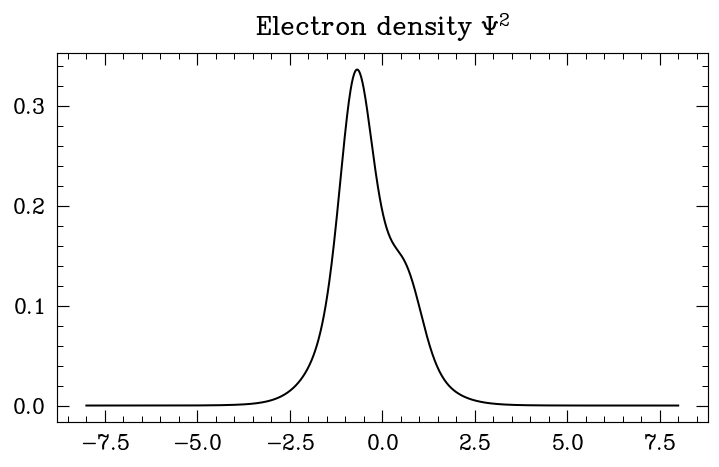

In [24]:
plt.figure(figsize=(7,4))
plt.title("Electron density $\Psi^{2}$")
plt.plot(x,density)

#Molecular Dynamics

In [30]:
import matplotlib.pyplot as plt
import numpy as np

r = np.linspace(0.01,3.0,500) # Make a radius vector
epsilon = 1 # Energy minimum
sigma = 1 # Distance to zero crossing point
E_LJ = 4*epsilon*((sigma/r)**12-(sigma/r)**6) # Lennard-Jones potential

plt.figure(figsize=[6,6])
plt.plot(r,E_LJ,'r-',linewidth=1,label="LJ pot") # Red line is unshifted LJ

# The cutoff and shifting value
Rcutoff = 2.5
phicutoff = 4.0/(Rcutoff**12)-4.0/(Rcutoff**6) # Shifts the potential so at the cutoff the potential goes to zero

E_LJ_shift = E_LJ - phicutoff # Subtract the value of the potential at r=2.5

plt.plot(r[:415],E_LJ_shift[:415],'b-',linewidth=1,label="LJ pot shifted") # Blue line is shifted

#Plot formatting
plt.title("Lennard-Jones potential",fontsize=20) # Removed TeX formatting from title
plt.xlim([0.0,3.0])
plt.ylim([-1.5,1.5])
plt.ylabel("E_LJ/epsilon",fontsize=20) # Removed TeX formatting from ylabel
plt.xlabel("r/sigma",fontsize=20) # Removed TeX formatting from xlabel
plt.legend(frameon=False,fontsize=20)
plt.axhline(0, color='grey',linestyle='--',linewidth=2)
plt.axvline(1, color='grey',linestyle='--',linewidth=2)

Error in callback <function _draw_all_if_interactive at 0x7b730db6f1c0> (for post_execute):


RuntimeError: Failed to process string with tex because latex could not be found

RuntimeError: Failed to process string with tex because latex could not be found

<Figure size 720x720 with 1 Axes>

In [31]:
def Compute_Forces(pos,acc,ene_pot,epsilon,BoxSize,DIM,N):
    # Compute forces on positions using the Lennard-Jones potential
    # Uses double nested loop which is slow O(N^2) time unsuitable for large systems
    Sij = np.zeros(DIM) # Box scaled units
    Rij = np.zeros(DIM) # Real space units

    #Set all variables to zero
    ene_pot = ene_pot*0.0
    acc = acc*0.0
    virial=0.0

    # Loop over all pairs of particles
    for i in range(N-1):
        for j in range(i+1,N): #i+1 to N ensures we do not double count
            Sij = pos[i,:]-pos[j,:] # Distance in box scaled units
            for l in range(DIM): # Periodic interactions
                if (np.abs(Sij[l])>0.5):
                    Sij[l] = Sij[l] - np.copysign(1.0,Sij[l]) # If distance is greater than 0.5  (scaled units) then subtract 0.5 to find periodic interaction distance.

            Rij = BoxSize*Sij # Scale the box to the real units in this case reduced LJ units
            Rsqij = np.dot(Rij,Rij) # Calculate the square of the distance

            if(Rsqij < Rcutoff**2):
                # Calculate LJ potential inside cutoff
                # We calculate parts of the LJ potential at a time to improve the efficieny of the computation (most important for compiled code)
                rm2 = 1.0/Rsqij # 1/r^2
                rm6 = rm2**3.0 # 1/r^6
                rm12 = rm6**2.0 # 1/r^12
                phi = epsilon*(4.0*(rm12-rm6)-phicutoff) # 4[1/r^12 - 1/r^6] - phi(Rc) - we are using the shifted LJ potential
                # The following is dphi = -(1/r)(dV/dr)
                dphi = epsilon*24.0*rm2*(2.0*rm12-rm6) # 24[2/r^14 - 1/r^8]
                ene_pot[i] = ene_pot[i]+0.5*phi # Accumulate energy
                ene_pot[j] = ene_pot[j]+0.5*phi # Accumulate energy
                virial = virial + dphi*np.sqrt(Rsqij) # Virial is needed to calculate the pressure
                acc[i,:] = acc[i,:]+dphi*Sij # Accumulate forces
                acc[j,:] = acc[j,:]-dphi*Sij # (Fji=-Fij)
    return acc, np.sum(ene_pot)/N, -virial/DIM # return the acceleration vector, potential energy and virial coefficient


In [32]:
def Calculate_Temperature(vel,BoxSize,DIM,N):

    ene_kin = 0.0

    for i in range(N):
        real_vel = BoxSize*vel[i,:]
        ene_kin = ene_kin + 0.5*np.dot(real_vel,real_vel)

    ene_kin_aver = 1.0*ene_kin/N
    temperature = 2.0*ene_kin_aver/DIM

    return ene_kin_aver,temperature

In [33]:
DIM = 2 # Dimensions
N = 32

BoxSize = 10.0#6.35

volume  = BoxSize**DIM
density = N / volume
print("volume = ", volume, " density = ", density)

pos = np.zeros([N,DIM])

pos = np.genfromtxt('output.dat',skip_header=1) # Load positions from file
pos = pos[:,:DIM]/BoxSize

MassCentre = np.sum(pos,axis=0)/N

for i in range(DIM):
    pos[:,i] = pos[:,i]-MassCentre[i]

volume =  100.0  density =  0.32


FileNotFoundError: output.dat not found.

In [34]:
# Setting up the simulation
NSteps=10000 # Number of steps
deltat = 0.0032 # Time step in reduced time units
TRequested = 0.5# #Reduced temperature
DumpFreq = 100 # Save the position to file every DumpFreq steps
epsilon = 1.0 # LJ parameter for the energy between particles

# Main MD loop
def main(pos,NSteps,deltat,TRequested,DumpFreq,epsilon,BoxSize,DIM):

    # Vectors to store parameter values at each step
    N = np.size(pos[:,1])
    ene_kin_aver = np.ones(NSteps)
    ene_pot_aver = np.ones(NSteps)
    temperature = np.ones(NSteps)
    virial = np.ones(NSteps)
    pressure = np.ones(NSteps)
    ene_pot = np.ones(N)

    vel = (np.random.randn(N,DIM)-0.5)
    acc = (np.random.randn(N,DIM)-0.5)

    # Open file which we will save the outputs to
    f = open('traj.xyz', 'w')

    for k in range(NSteps):

        # Refold positions according to periodic boundary conditions
        for i in range(DIM):
            period = np.where(pos[:,i] > 0.5)
            pos[period,i]=pos[period,i]-1.0
            period = np.where(pos[:,i] < -0.5)
            pos[period,i]=pos[period,i]+1.0

        # r(t+dt) modify positions according to velocity and acceleration
        pos = pos + deltat*vel + 0.5*(deltat**2.0)*acc # Step 1

        # Calculate temperature
        ene_kin_aver[k],temperature[k] = Calculate_Temperature(vel,BoxSize,DIM,N)

        # Rescale velocities and take half step
        chi = np.sqrt(TRequested/temperature[k])
        vel = chi*vel + 0.5*deltat*acc # v(t+dt/2) Step 2

        # Compute forces a(t+dt),ene_pot,virial
        acc, ene_pot_aver[k], virial[k] = Compute_Forces(pos,acc,ene_pot,epsilon,BoxSize,DIM,N) # Step 3

        # Complete the velocity step
        vel = vel + 0.5*deltat*acc # v(t+dt/2) Step 4

        # Calculate temperature
        ene_kin_aver[k],temperature[k] = Calculate_Temperature(vel,BoxSize,DIM,N)

        # Calculate pressure
        pressure[k]= density*temperature[k] + virial[k]/volume


        # Print output to file every DumpFreq number of steps
        if(k%DumpFreq==0): # The % symbol is the modulus so if the Step is a whole multiple of DumpFreq then print the values

            f.write("%s\n" %(N)) # Write the number of particles to file
            # Write all of the quantities at this step to the file
            f.write("Energy %s, Temperature %.5f\n" %(ene_kin_aver[k]+ene_pot_aver[k],temperature[k]))
            for n in range(N): # Write the positions to file
                f.write("X"+" ")
                for l in range(DIM):
                    f.write(str(pos[n][l]*BoxSize)+" ")
                f.write("\n")

            if(DIM==2):
                import matplotlib.pyplot as plt
                from IPython import display
                plt.cla()
                plt.xlim(-0.5*BoxSize,0.5*BoxSize)
                plt.ylim(-0.5*BoxSize,0.5*BoxSize)
                for i in range(N):
                    plt.plot(pos[i,0]*BoxSize,pos[i,1]*BoxSize,'o',markersize=20,)
                display.clear_output(wait=True)
                display.display(plt.gcf())
        #print(ene_kin_aver[k], ene_pot_aver[k], temperature[k], pressure[k])

    f.close() # Close the file

    return ene_kin_aver, ene_pot_aver, temperature, pressure, pos

In [35]:
ene_kin_aver, ene_pot_aver, temperature, pressure, pos = main(pos,NSteps,deltat,TRequested,DumpFreq,epsilon,BoxSize,DIM)

RuntimeError: Failed to process string with tex because latex could not be found

<Figure size 720x720 with 1 Axes>

Error in callback <function _draw_all_if_interactive at 0x7b730db6f1c0> (for post_execute):


RuntimeError: Failed to process string with tex because latex could not be found

RuntimeError: Failed to process string with tex because latex could not be found

<Figure size 720x720 with 1 Axes>

In [36]:
# Plot all of the quantities
def plot():
    plt.figure(figsize=[7,12])
    plt.subplot(4, 1, 1)
    plt.plot(ene_kin_aver,'k-')
    plt.ylabel(r"$E_{K}$", fontsize=20)
    plt.subplot(4, 1, 2)
    plt.plot(ene_pot_aver,'k-')
    plt.ylabel(r"$E_{P}$", fontsize=20)
    plt.subplot(4, 1, 3)
    plt.plot(temperature,'k-')
    plt.ylabel(r"$T$", fontsize=20)
    plt.subplot(4, 1, 4)
    plt.plot(pressure,'k-')
    plt.ylabel(r"$P$", fontsize=20)
    plt.show()

plot()

RuntimeError: Failed to process string with tex because latex could not be found

<Figure size 840x1440 with 4 Axes>